In [ ]:
%pip install -q "airavata-python-sdk[notebook]"
import airavata_jupyter_magic

%authenticate
%request_runtime hpc_cpu --file=cybershuttle.yml --walltime=60 --use=expanse:shared
%switch_runtime hpc_cpu

# QCArchive+QCMLForge Demo with CyberShuttle

The first half of this demo shows how to use QCArchive to setup a dataset
and run computations with ease. The compute resource can be local or
through CyberShuttle. 

The second half of this demo shows how one can consume the generated data
to train AP-Net2 and dAPNet2 models through QCMLForge. 

In [ ]:
import psi4
from pprint import pprint as pp
import pandas as pd
import numpy as np
import re
from qm_tools_aw import tools
from pprint import pprint as pp
# QCElemental Imports
from qcelemental.models import Molecule
import qcelemental as qcel
# Dataset Imports
from qcportal import PortalClient
from qcportal.singlepoint import SinglepointDataset, SinglepointDatasetEntry, QCSpecification
from qcportal.manybody import ManybodyDataset, ManybodyDatasetEntry, ManybodyDatasetSpecification, ManybodySpecification
from torch import manual_seed

manual_seed(42)

h2kcalmol = qcel.constants.hartree2kcalmol

# QCArchive Setup

In [1]:
from setup_qcfractal import setup_qcarchive_qcfractal
import os

setup_qcarchive_qcfractal(
    QCF_BASE_FOLDER=os.path.join(os.getcwd(), "qcfractal"),
    start=False,
    reset=False,
    db_config={
        "name": None,
        "enable_security": "false",
        "allow_unauthenticated_read": None,
        "logfile": None,
        "loglevel": None,
        "service_frequency": 5,
        "max_active_services": None,
        "heartbeat_frequency": 60,
        "log_access": None,
        "database": {
            "base_folder": None,
            "host": None,
            "port": 5432,
            "database_name": "qca",
            "username": None,
            "password": None,
            "own": None,
        },
        "api": {
            "host": None,
            "port": 7777,
            "secret_key": None,
            "jwt_secret_key": None,
        },
    },
    resources_config={
            "update_frequency": 5,
            "cores_per_worker": 8,
            "max_workers": 3,
            "memory_per_worker": 20,
    }
)

/home/amwalla3/gits/cybershuttle_demo/qcfractal

--------------------------------------------------------------------------------
Python executable:  /home/amwalla3/miniconda3/envs/p4_qcml/bin/python
QCFractal version:  0.59
QCFractal alembic revision:  d5988aa750ae
pg_ctl path:  /home/amwalla3/miniconda3/envs/p4_qcml/bin/pg_ctl
PostgreSQL server version:  PostgreSQL 17.4 on x86_64-conda-linux-gnu, compiled by x86_64-conda-linux-gnu-cc (conda-forge gcc 13.3.0-2) 13.3.0, 64-bit
--------------------------------------------------------------------------------


Displaying QCFractal configuration below
--------------------------------------------------------------------------------
access_log_keep: 0
allow_unauthenticated_read: true
api:
  extra_flask_options: null
  extra_waitress_options: null
  host: localhost
  jwt_access_token_expires: 3600
  jwt_refresh_token_expires: 86400
  jwt_secret_key: baMlfVEJEqa0N7yGwETn16OryA7TWPEPaQhJox8SHes
  num_threads_per_worker: 4
  port: 7777
  secret

In [ ]:
!qcfractal-server --config=`pwd`/qcfractal/qcfractal_config.yaml start > qcfractal_server.log & disown

In [ ]:
!qcfractal-compute-manager --config=`pwd`/qcfractal/resources.yml > qcfractal_compute.log & disown

In [ ]:
# NOTE kill server when finished by removing the # and executing:
# !ps aux | grep qcfractal | awk '{ print $2 }' | xargs kill -9

# QCArchive single point example

In [2]:
# Running a single job
client = PortalClient("http://localhost:7777", verify=False)
mol = Molecule.from_data(
    """
     0 1
     O  -1.551007  -0.114520   0.000000
     H  -1.934259   0.762503   0.000000
     H  -0.599677   0.040712   0.000000
     --
     0 1
     O   1.350625   0.111469   0.000000
     H   1.680398  -0.373741  -0.758561
     H   1.680398  -0.373741   0.758561

     units angstrom
     no_reorient
     symmetry c1
"""
)

psi4.set_options(
    {"basis": "aug-cc-pvdz", "scf_type": "df", "e_convergence": 6, "freeze_core": True}
)

client.add_singlepoints(
    [mol],
    "psi4",
    driver="energy",
    method="b3lyp",
    basis="aug-cc-pvdz",
    keywords={"scf_type": "df", "e_convergence": 6, "freeze_core": True},
    tag="local",
)

# Can print records
# for rec in client.query_records():
#     pp(rec.dict)
#     pp(rec.error)

(InsertMetadata(error_description=None, errors=[], inserted_idx=[], existing_idx=[0]),
 [1])

# QCArchive dataset examples

In [3]:
# Creating a QCArchive Dataset...
# Load in a dataset from a recent Sherrill work (Levels of SAPT II)
df_LoS = pd.read_pickle("./combined_df_subset_358.pkl")
print(df_LoS[['Benchmark', 'SAPT2+3(CCD)DMP2 TOTAL ENERGY aqz', 'MP2 IE atz', 'SAPT0 TOTAL ENERGY adz' ]])

# Limit to 100 molecules with maximum of 16 atoms to keep computational cost down
df_LoS['size'] = df_LoS['atomic_numbers'].apply(lambda x: len(x))
df_LoS = df_LoS[df_LoS['size'] <= 16]
df_LoS = df_LoS.sample(200, random_state=42, axis=0).copy()
df_LoS.reset_index(drop=True, inplace=True)
print(df_LoS['size'].describe())

# Create QCElemntal Molecules to generate the dataset
def qcel_mols(row):
    """
    Convert the row to a qcel molecule
    """
    atomic_numbers = [row['atomic_numbers'][row['monAs']], row['atomic_numbers'][row['monBs']]]
    coords = [row['coordinates'][row['monAs']], row['coordinates'][row['monBs']]]
    cm = [
        [row['monA_charge'], row['monA_multiplicity']],
        [row['monB_charge'], row['monB_multiplicity']],
     ]
    return tools.convert_pos_carts_to_mol(atomic_numbers, coords, cm)
df_LoS['qcel_molecule'] = df_LoS.apply(qcel_mols, axis=1)
geoms = df_LoS['qcel_molecule'].tolist()
ref_IEs = df_LoS['Benchmark'].tolist()
sapt0_adz = (df_LoS['SAPT0 TOTAL ENERGY adz'] * h2kcalmol).tolist()

     Benchmark SAPT2+3(CCD)DMP2 TOTAL ENERGY aqz  MP2 IE atz  \
0      -10.248                         -0.016681   -0.015629   
1      -15.245                         -0.024763   -0.023012   
2       -3.517                         -0.005637   -0.005608   
3       -0.127                         -0.000187   -0.000194   
4       -8.990                         -0.014655   -0.013687   
5       -2.323                         -0.003811   -0.003584   
6      -15.811                         -0.025138   -0.024756   
7       -8.730                         -0.012774   -0.013415   
8      -23.841                         -0.038183   -0.036675   
9      -18.075                         -0.029348   -0.027063   
10      -1.861                         -0.002992   -0.002994   
11      -3.328                         -0.005401   -0.005262   
12     -14.614                          -0.02346   -0.022543   
13      -7.626                         -0.012446   -0.011745   
14     -21.002                         -

## Singlepoint Dataset

In [4]:
# Create client dataset

ds_name = 'S22-singlepoint'
client_datasets = [i['dataset_name'] for i in client.list_datasets()]
# Check if dataset already exists, if not create a new one
if ds_name not in client_datasets:
    ds = client.add_dataset("singlepoint", ds_name,
                            f"Dataset to contain {ds_name}")
    print(f"Added {ds_name} as dataset")
    # Insert entries into dataset
    entry_list = []
    for idx, mol in enumerate(geoms):
        extras = {
            "name": 'S22-' + str(idx),
            "idx": idx,
        }
        mol = Molecule.from_data(mol.dict(), extras=extras)
        ent = SinglepointDatasetEntry(name=extras['name'], molecule=mol)
        entry_list.append(ent)
    ds.add_entries(entry_list)
    print(f"Added {len(entry_list)} molecules to dataset")
else:
    ds = client.get_dataset("singlepoint", ds_name)
    print(f"Found {ds_name} dataset, using this instead")

print(ds)

Found S22-singlepoint dataset, using this instead
id=1 dataset_type='singlepoint' name='S22-singlepoint' description='Dataset to contain S22-singlepoint' tagline='' tags=[] group='default' visibility=True provenance={} default_tag='*' default_priority=<PriorityEnum.normal: 1> owner_user=None owner_group=None metadata={} extras={} contributed_values_=None attachments_=None auto_fetch_missing=True


In [ ]:
# Can delete the dataset if you want to start over. Need to know dataset_id
# client.delete_dataset(dataset_id=ds.id, delete_records=True)

In [ ]:
# Multipole Example
# method, basis = "hf", "sto-3g"
#
# # Set the QCSpecification (QM interaction energy in our case)
# spec = QCSpecification(
#     program="psi4",
#     driver="energy",
#     method=method,
#     basis=basis,
#     keywords={
#         "d_convergence": 8,
#         "dft_radial_points": 99,
#         "dft_spherical_points": 590,
#         "e_convergence": 10,
#         "guess": "sad",
#         "mbis_d_convergence": 9,
#         "mbis_radial_points": 99,
#         "mbis_spherical_points": 590,
#         "scf_properties": ["mbis_charges", "MBIS_VOLUME_RATIOS"],
#         "scf_type": "df",
#     },
#     protocols={"wavefunction": "orbitals_and_eigenvalues"},
# )
# ds.add_specification(name=f"psi4/{method}/{basis}", specification=spec)

In [5]:
# SAPT0 Example
method, basis = "SAPT0", "cc-pvdz"

# Set the QCSpecification (QM interaction energy in our case)
spec = QCSpecification(
    program="psi4",
    driver="energy",
    method=method,
    basis=basis,
    keywords={
        "scf_type": "df",
    },
)
ds.add_specification(name=f"psi4/{method}/{basis}", specification=spec)

InsertMetadata(error_description=None, errors=[], inserted_idx=[], existing_idx=[0])

In [6]:
# Run the computations
ds.submit()
print(f"Submitted {ds_name} dataset")

Submitted S22-singlepoint dataset


In [7]:
# Check the status of the dataset - can repeatedly run this to see the progress
ds.status()

{'psi4/SAPT0/cc-pvdz': {<RecordStatusEnum.complete: 'complete'>: 200}}

## Manybody Dataset

In [8]:
# Create client dataset
ds_name_mb = 'S22-manybody'
client_datasets = [i['dataset_name'] for i in client.list_datasets()]
# Check if dataset already exists, if not create a new one
if ds_name_mb not in client_datasets:
    print("Setting up new dataset:", ds_name_mb)
    ds_mb = client.add_dataset("manybody", ds_name_mb,
                            f"Dataset to contain {ds_name_mb}")
    print(f"Added {ds_name_mb} as dataset")
    # Insert entries into dataset
    entry_list = []
    for idx, mol in enumerate(geoms):
        ent = ManybodyDatasetEntry(name=f"S22-IE-{idx}", initial_molecule=mol)
        entry_list.append(ent)
    ds_mb.add_entries(entry_list)
    print(f"Added {len(entry_list)} molecules to dataset")
else:
    ds_mb = client.get_dataset("manybody", ds_name_mb)
    print(f"Found {ds_name_mb} dataset, using this instead")

print(ds_mb)

# Can delete the dataset if you want to start over. Need to know dataset_id
# client.delete_dataset(dataset_id=2, delete_records=True)

Found S22-manybody dataset, using this instead
id=2 dataset_type='manybody' name='S22-manybody' description='Dataset to contain S22-manybody' tagline='' tags=[] group='default' visibility=True provenance={} default_tag='*' default_priority=<PriorityEnum.normal: 1> owner_user=None owner_group=None metadata={} extras={} contributed_values_=None attachments_=None auto_fetch_missing=True


In [9]:
ds_mb.status()

{'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 200},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 200}}

In [10]:
# Set multiple levels of theory - you can add/remove levels as you desire.
# Computational scaling will get quite expensive with better methods and larger
# basis sets

methods = [
    'hf', 'pbe',
]
basis_sets = [
    '6-31g*'
]

for method in methods:
    for basis in basis_sets:
        # Set the QCSpecification (QM interaction energy in our case)
        qc_spec_mb = QCSpecification(
            program="psi4",
            driver="energy",
            method=method,
            basis=basis,
            keywords={
                "d_convergence": 8,
                "scf_type": "df",
            },
        )

        spec_mb = ManybodySpecification(
            program='qcmanybody',
            bsse_correction=['cp'],
            levels={
                1: qc_spec_mb,
                2: qc_spec_mb,
            },
        )
        print("spec_mb", spec_mb)

        ds_mb.add_specification(name=f"psi4/{method}/{basis}", specification=spec_mb)

        # Run the computations
        ds_mb.submit()
        print(f"Submitted {ds_name} dataset")
# Check the status of the dataset - can repeatedly run this to see the progress
ds_mb.status()

spec_mb program='qcmanybody' levels={1: QCSpecification(program='psi4', driver=<SinglepointDriver.energy: 'energy'>, method='hf', basis='6-31g*', keywords={'d_convergence': 8, 'scf_type': 'df'}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>)), 2: QCSpecification(program='psi4', driver=<SinglepointDriver.energy: 'energy'>, method='hf', basis='6-31g*', keywords={'d_convergence': 8, 'scf_type': 'df'}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>))} bsse_correction=[<BSSECorrectionEnum.cp: 'cp'>] keywords=ManybodyKeywords(return_total_data=False) protocols={}
Submitted S22-singlepoint dataset
spec_mb program='qcmanybody' levels={

{'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 200},
 'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 200}}

In [11]:
pp(ds.status())
pp(ds_mb.status())

{'psi4/SAPT0/cc-pvdz': {<RecordStatusEnum.complete: 'complete'>: 200}}
{'psi4/hf/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 200},
 'psi4/pbe/6-31g*': {<RecordStatusEnum.complete: 'complete'>: 200}}


In [12]:
pp(ds)
pp(ds_mb)
pp(ds_mb.computed_properties)

SinglepointDataset(id=1, dataset_type='singlepoint', name='S22-singlepoint', description='Dataset to contain S22-singlepoint', tagline='', tags=[], group='default', visibility=True, provenance={}, default_tag='*', default_priority=<PriorityEnum.normal: 1>, owner_user=None, owner_group=None, metadata={}, extras={}, contributed_values_=None, attachments_=None, auto_fetch_missing=True)
ManybodyDataset(id=2, dataset_type='manybody', name='S22-manybody', description='Dataset to contain S22-manybody', tagline='', tags=[], group='default', visibility=True, provenance={}, default_tag='*', default_priority=<PriorityEnum.normal: 1>, owner_user=None, owner_group=None, metadata={}, extras={}, contributed_values_=None, attachments_=None, auto_fetch_missing=True)
{'psi4/hf/6-31g*': ['results',
                    'mc_results',
                    'ret_energy',
                    'energy_body_dict',
                    'component_properties'],
 'psi4/pbe/6-31g*': ['results',
                     'mc

# Data Assembly

While you can execute the following blocks before all computations are complete, it is recommended to wait until all computations are complete to continue.

In [13]:
# Singlepoint data assemble
def assemble_singlepoint_data(record):
    record_dict = record.dict()
    qcvars = record_dict["properties"]
    level_of_theory = f"{record_dict['specification']['method']}/{record_dict['specification']['basis']}"
    sapt_energies = np.array([np.nan, np.nan, np.nan, np.nan, np.nan])
    if "mbis charges" in qcvars:
        charges = qcvars["mbis charges"]
        dipoles = qcvars["mbis dipoles"]
        quadrupoles = qcvars["mbis quadrupoles"]
        n = len(charges)
        charges = np.reshape(charges, (n, 1))
        dipoles = np.reshape(dipoles, (n, 3))
        quad = np.reshape(quadrupoles, (n, 3, 3))

        quad = [q[np.triu_indices(3)] for q in quad]
        quadrupoles = np.array(quad)
        multipoles = np.concatenate(
            [charges, dipoles, quadrupoles], axis=1)
        return (
        record.molecule,
        qcvars['mbis volume ratios'],
        qcvars['mbis valence widths'],
        qcvars['mbis radial moments <r^2>'],
        qcvars['mbis radial moments <r^3>'],
        qcvars['mbis radial moments <r^4>'],
        record.molecule.atomic_numbers,
        record.molecule.geometry * qcel.constants.bohr2angstroms,
        multipoles,
        int(record.molecule.molecular_charge),
        record.molecule.molecular_multiplicity,
        sapt_energies,
        )
    else:
        sapt_energies[0] = qcvars['sapt total energy']
        sapt_energies[1] = qcvars['sapt elst energy']
        sapt_energies[2] = qcvars['sapt exch energy']
        sapt_energies[3] = qcvars['sapt ind energy']
        sapt_energies[4] = qcvars['sapt disp energy']
        return (
        record.molecule,
        None,
        None,
        None,
        None,
        None,
        record.molecule.atomic_numbers,
        record.molecule.geometry * qcel.constants.bohr2angstroms,
        None,
        int(record.molecule.molecular_charge),
        record.molecule.molecular_multiplicity,
        sapt_energies,
        )




def assemble_singlepoint_data_value_names():
    return [
        'qcel_molecule',
        "volume ratios",
        "valence widths",
        "radial moments <r^2>",
        "radial moments <r^3>",
        "radial moments <r^4>",
        "Z",
        "R",
        "cartesian_multipoles",
        "TQ",
        "molecular_multiplicity",
        "SAPT Energies"
    ]

df = ds.compile_values(
    value_call=assemble_singlepoint_data,
    value_names=assemble_singlepoint_data_value_names(),
    unpack=True,
)
pp(df.columns.tolist())
df_sapt0 = df['psi4/SAPT0/cc-pvdz']

[('psi4/SAPT0/cc-pvdz', 'qcel_molecule'),
 ('psi4/SAPT0/cc-pvdz', 'volume ratios'),
 ('psi4/SAPT0/cc-pvdz', 'valence widths'),
 ('psi4/SAPT0/cc-pvdz', 'radial moments <r^2>'),
 ('psi4/SAPT0/cc-pvdz', 'radial moments <r^3>'),
 ('psi4/SAPT0/cc-pvdz', 'radial moments <r^4>'),
 ('psi4/SAPT0/cc-pvdz', 'Z'),
 ('psi4/SAPT0/cc-pvdz', 'R'),
 ('psi4/SAPT0/cc-pvdz', 'cartesian_multipoles'),
 ('psi4/SAPT0/cc-pvdz', 'TQ'),
 ('psi4/SAPT0/cc-pvdz', 'molecular_multiplicity'),
 ('psi4/SAPT0/cc-pvdz', 'SAPT Energies')]


In [14]:
def assemble_data(record):
    record_dict = record.dict()
    qcvars = record_dict["properties"]
    level_of_theory = f"{record_dict['specification']['levels'][2]['method']}/{record_dict['specification']['levels'][2]['basis']}"
    CP_IE = qcvars['results']['cp_corrected_interaction_energy'] * h2kcalmol
    NOCP_IE = qcvars['results'].get('nocp_corrected_interaction_energy', np.nan) * h2kcalmol
    return (
    record.initial_molecule,
    CP_IE,
    NOCP_IE,
    record.initial_molecule.atomic_numbers,
    record.initial_molecule.geometry * qcel.constants.bohr2angstroms,
    int(record.initial_molecule.molecular_charge),
    record.initial_molecule.molecular_multiplicity,
    )

def assemble_data_value_names():
    return [
        'qcel_molecule',
        "CP_IE",
        "NOCP_IE",
        "Z",
        "R",
        "TQ",
        "molecular_multiplicity"
    ]

df_mb = ds_mb.compile_values(
    value_call=assemble_data,
    value_names=assemble_data_value_names(),
    unpack=True,
)

pp(df_mb.columns.tolist())

[('psi4/hf/6-31g*', 'qcel_molecule'),
 ('psi4/pbe/6-31g*', 'qcel_molecule'),
 ('psi4/hf/6-31g*', 'CP_IE'),
 ('psi4/pbe/6-31g*', 'CP_IE'),
 ('psi4/hf/6-31g*', 'NOCP_IE'),
 ('psi4/pbe/6-31g*', 'NOCP_IE'),
 ('psi4/hf/6-31g*', 'Z'),
 ('psi4/pbe/6-31g*', 'Z'),
 ('psi4/hf/6-31g*', 'R'),
 ('psi4/pbe/6-31g*', 'R'),
 ('psi4/hf/6-31g*', 'TQ'),
 ('psi4/pbe/6-31g*', 'TQ'),
 ('psi4/hf/6-31g*', 'molecular_multiplicity'),
 ('psi4/pbe/6-31g*', 'molecular_multiplicity')]


In [15]:
from cdsg_plot import error_statistics

df_sapt0['sapt0 total energes'] = df_sapt0['SAPT Energies'].apply(lambda x: x[0] * h2kcalmol)
df_plot = pd.DataFrame(
    {
        "qcel_molecule": df_mb["psi4/pbe/6-31g*"]["qcel_molecule"],
        "HF/6-31G*": df_mb["psi4/hf/6-31g*"]["CP_IE"],
        "PBE/6-31G*": df_mb["psi4/pbe/6-31g*"]["CP_IE"],
        'SAPT0/cc-pvdz': df_sapt0['sapt0 total energes'].values,
    }
)
print(df_plot)
id = [int(i[7:]) for i in df_plot.index]
df_plot['id'] = id
df_plot.sort_values(by='id', inplace=True, ascending=True)
df_plot['reference'] = ref_IEs
df_plot['SAPT0/aug-cc-pvdz'] = sapt0_adz
df_plot['HF/6-31G* error'] = (df_plot['HF/6-31G*'] - df_plot['reference']).astype(float)
df_plot['PBE/6-31G* error'] = (df_plot['PBE/6-31G*'] - df_plot['reference']).astype(float)
df_plot['SAPT0/cc-pvdz error'] = (df_plot['SAPT0/cc-pvdz'] - df_plot['reference']).astype(float)
df_plot['SAPT0/aug-cc-pvdz error'] = (df_plot['SAPT0/aug-cc-pvdz'] - df_plot['reference']).astype(float)
pd.set_option('display.max_rows', None)
print(df_plot[['PBE/6-31G*', 'SAPT0/cc-pvdz', 'reference', "SAPT0/aug-cc-pvdz"]])
print(df_plot[['PBE/6-31G* error', 'SAPT0/cc-pvdz error', "SAPT0/aug-cc-pvdz error"]].describe())

                                                qcel_molecule   HF/6-31G*  \
entry                                                                       
S22-IE-0    Molecule(name='C2H4O4', formula='C2H4O4', hash...   -15.29702   
S22-IE-1    Molecule(name='CH7NO', formula='CH7NO', hash='...   -4.790555   
S22-IE-10   Molecule(name='CH7NO', formula='CH7NO', hash='...    -1.21354   
S22-IE-100  Molecule(name='C2H4O4', formula='C2H4O4', hash...  -14.819454   
S22-IE-101  Molecule(name='C7H7N', formula='C7H7N', hash='...   -2.343814   
S22-IE-102  Molecule(name='C2H5NO3', formula='C2H5NO3', ha...   -9.267878   
S22-IE-103  Molecule(name='C3H9NO2', formula='C3H9NO2', ha...   -3.610811   
S22-IE-104  Molecule(name='H4NO', formula='H4NO-', hash='6...  -18.081059   
S22-IE-105  Molecule(name='C6H8O', formula='C6H8O', hash='...   -1.427525   
S22-IE-106  Molecule(name='CH7NO', formula='CH7NO', hash='...   -5.705103   
S22-IE-107  Molecule(name='CH6O2', formula='CH6O2', hash='...   -4.181506   

# Plotting the interaction energy errors

Plotting S22-IE.png
(-15, 15)
lower_bound = -15, upper_bound = 20, inc = 5
S22-IE_violin.png


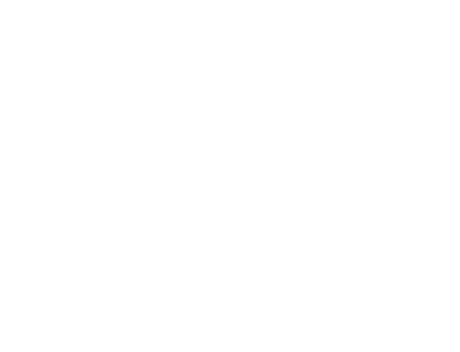

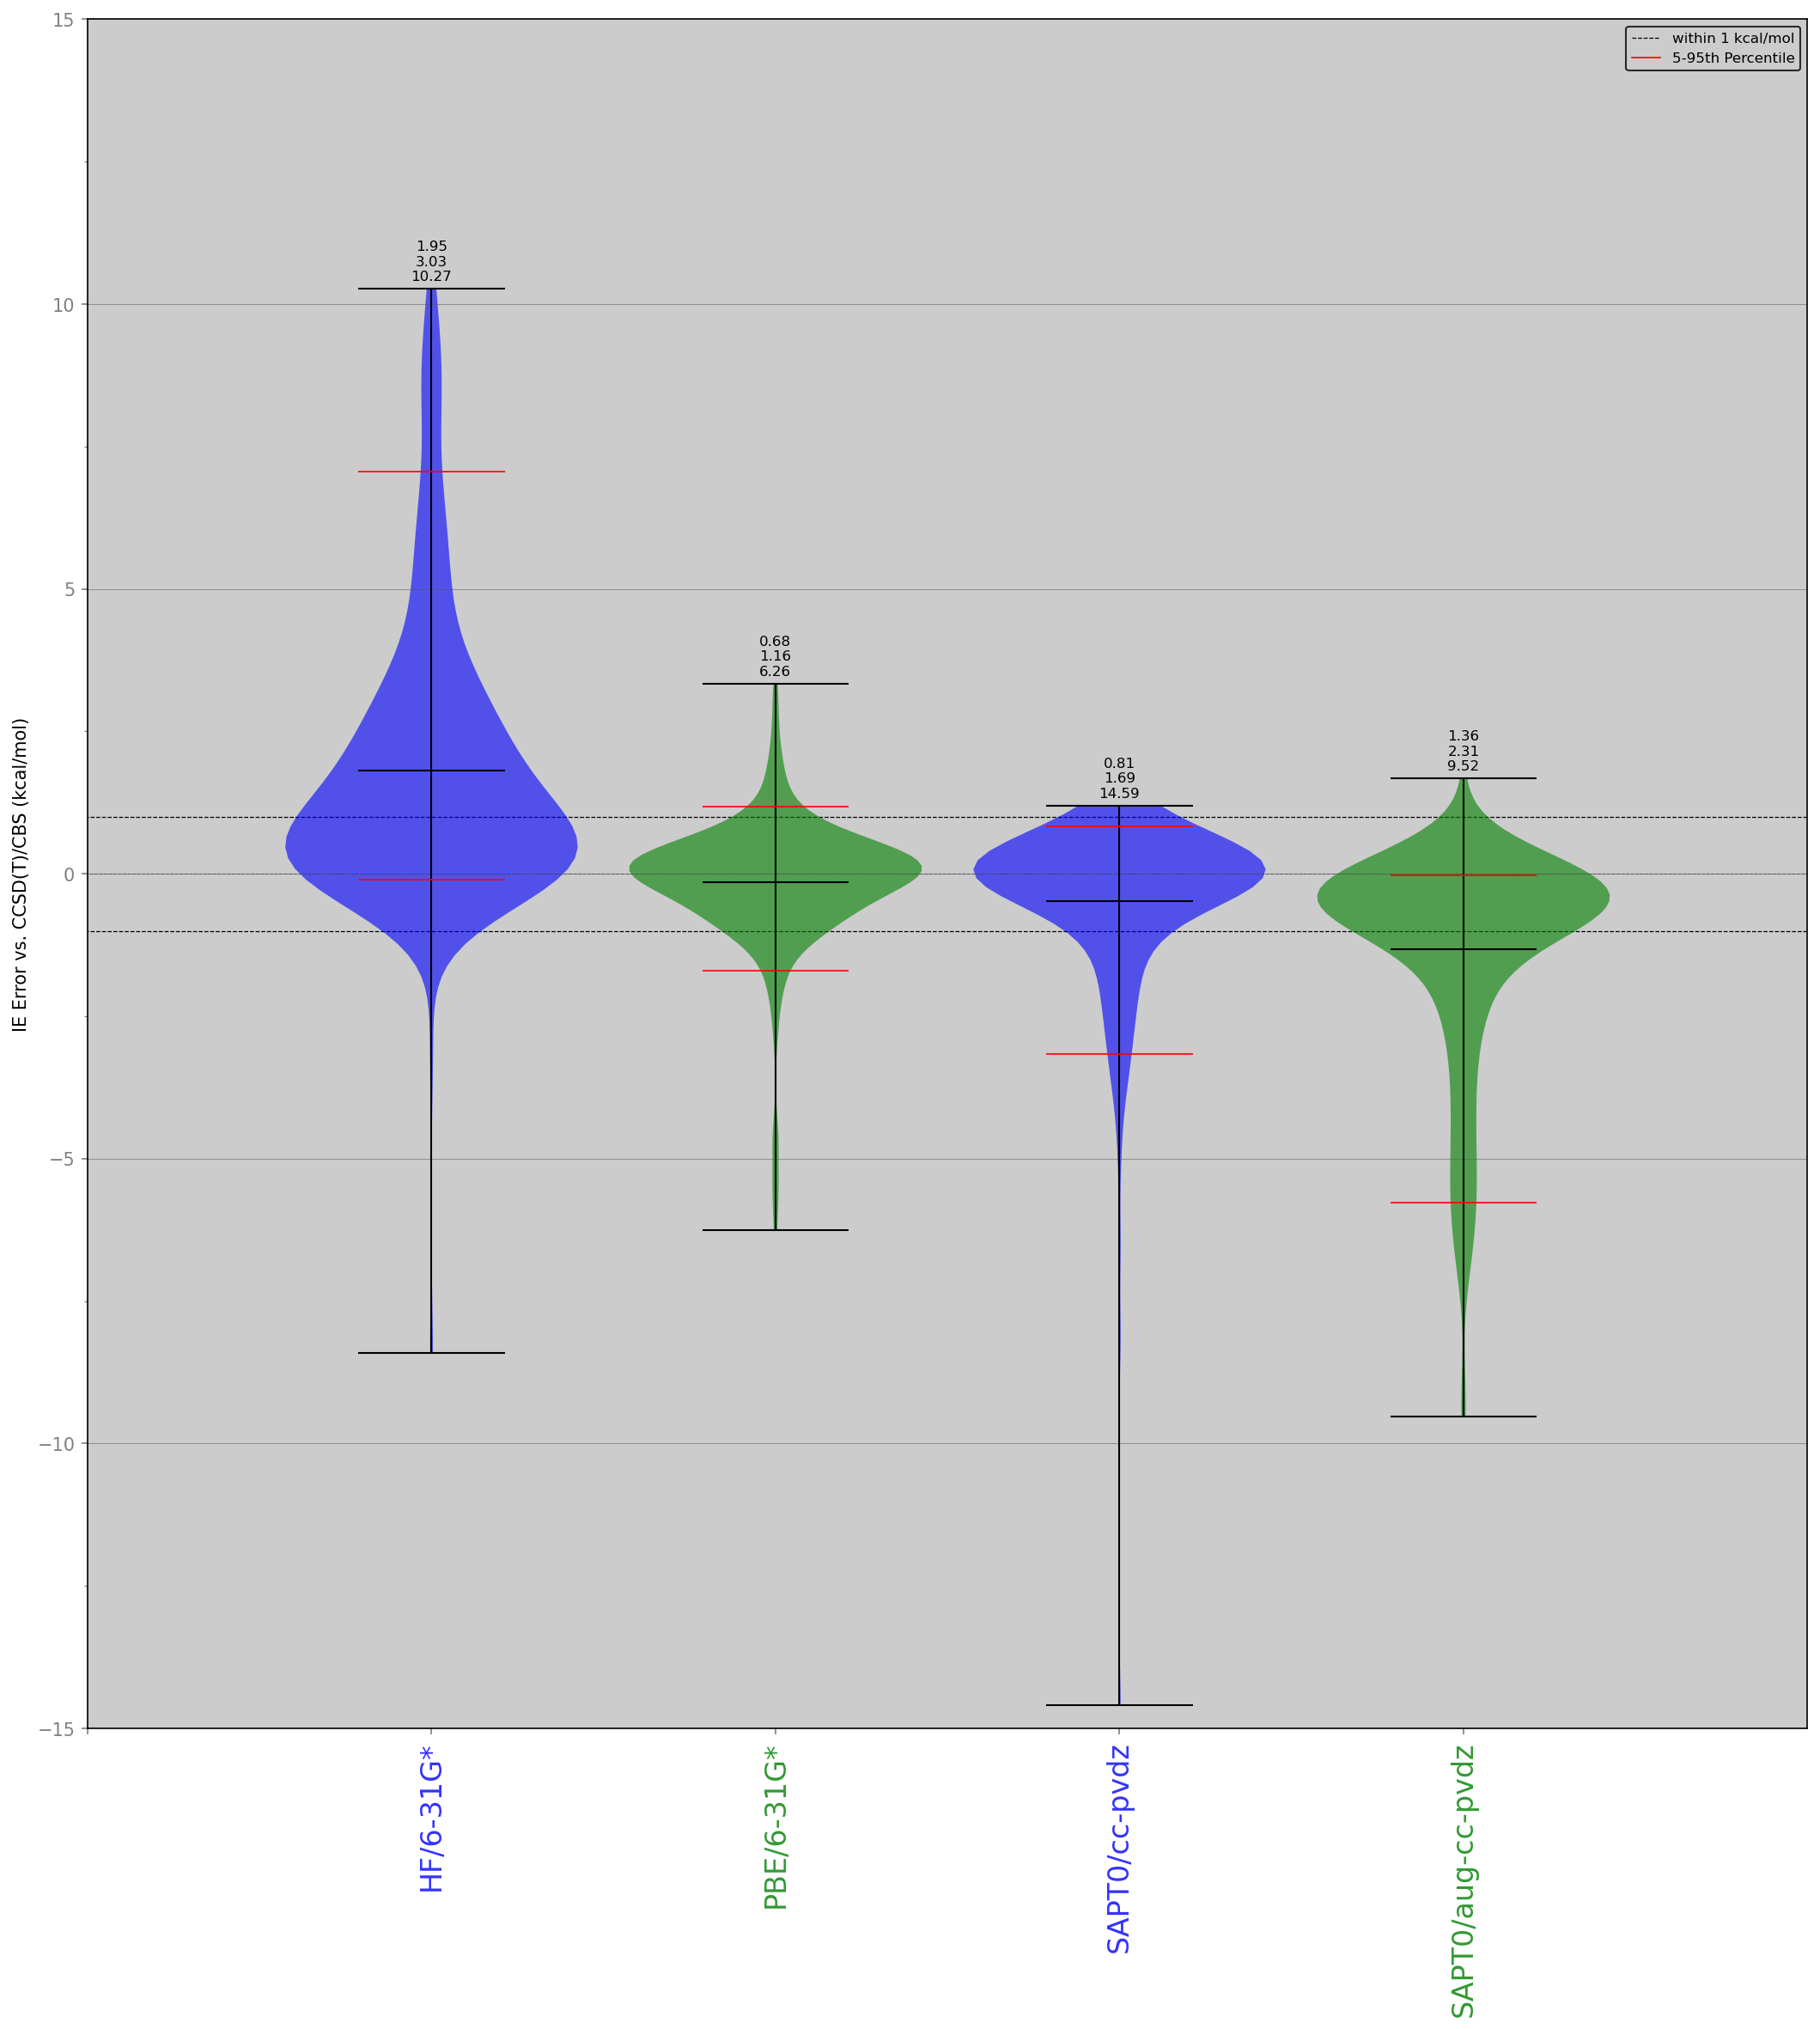

In [16]:
error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        # "B3LYP/6-31G*": "B3LYP/6-31G* error",
        "SAPT0/cc-pvdz": "SAPT0/cc-pvdz error",
        "SAPT0/aug-cc-pvdz": "SAPT0/aug-cc-pvdz error",
    },
    output_filename="S22-IE.png",
    figure_size=(6, 6),
    x_label_fontsize=16,
    ylim=(-15, 15),
    rcParams={},
    usetex=False,
    ylabel=r"IE Error vs. CCSD(T)/CBS (kcal/mol)",
)

# QCMLForge

## AP-Net2 inference

In [17]:
import apnet_pt
from apnet_pt.AtomPairwiseModels.apnet2 import APNet2Model
from apnet_pt.AtomModels.ap2_atom_model import AtomModel

atom_model = AtomModel().set_pretrained_model(model_id=0)
ap2 = APNet2Model(atom_model=atom_model.model).set_pretrained_model(model_id=0)
ap2.atom_model = atom_model.model
apnet2_ies_predicted = ap2.predict_qcel_mols(
    mols=df_plot['qcel_molecule'].tolist(),
    batch_size=16
)

running on the CPU
running on the CPU
self.dataset=None


                APNet2  reference
entry                            
S22-IE-43   -39.262084    -26.064
S22-IE-9    -30.105849    -19.650
S22-IE-69   -27.380183    -19.027
S22-IE-0    -25.293842    -18.075
S22-IE-76   -29.233538    -22.850
S22-IE-100  -22.756636    -16.873
S22-IE-45   -18.233848    -12.463
S22-IE-117  -27.748687    -21.990
S22-IE-64   -19.409623    -13.932
S22-IE-130  -13.412020     -8.021
S22-IE-116  -16.008143    -10.711
S22-IE-115  -23.494008    -18.409
S22-IE-119  -22.505377    -17.450
S22-IE-176  -15.765331    -10.725
S22-IE-96   -17.821088    -12.862
S22-IE-194  -11.453742     -6.556
S22-IE-23   -20.328392    -15.517
S22-IE-5    -23.582037    -18.790
S22-IE-102  -21.078200    -16.312
S22-IE-42   -22.009603    -17.679
S22-IE-193  -22.539459    -18.250
S22-IE-48   -23.176219    -19.090
S22-IE-36   -14.025411    -10.027
S22-IE-149  -23.653126    -19.819
S22-IE-153  -16.295949    -12.697
S22-IE-57   -19.317617    -15.763
S22-IE-145  -21.675399    -18.461
S22-IE-33   -1

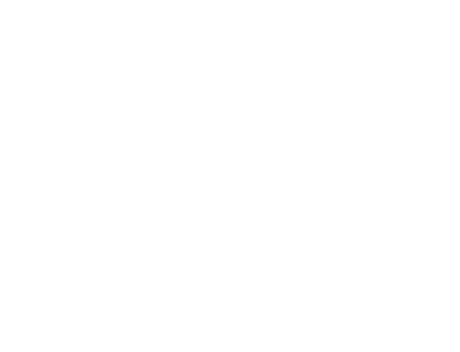

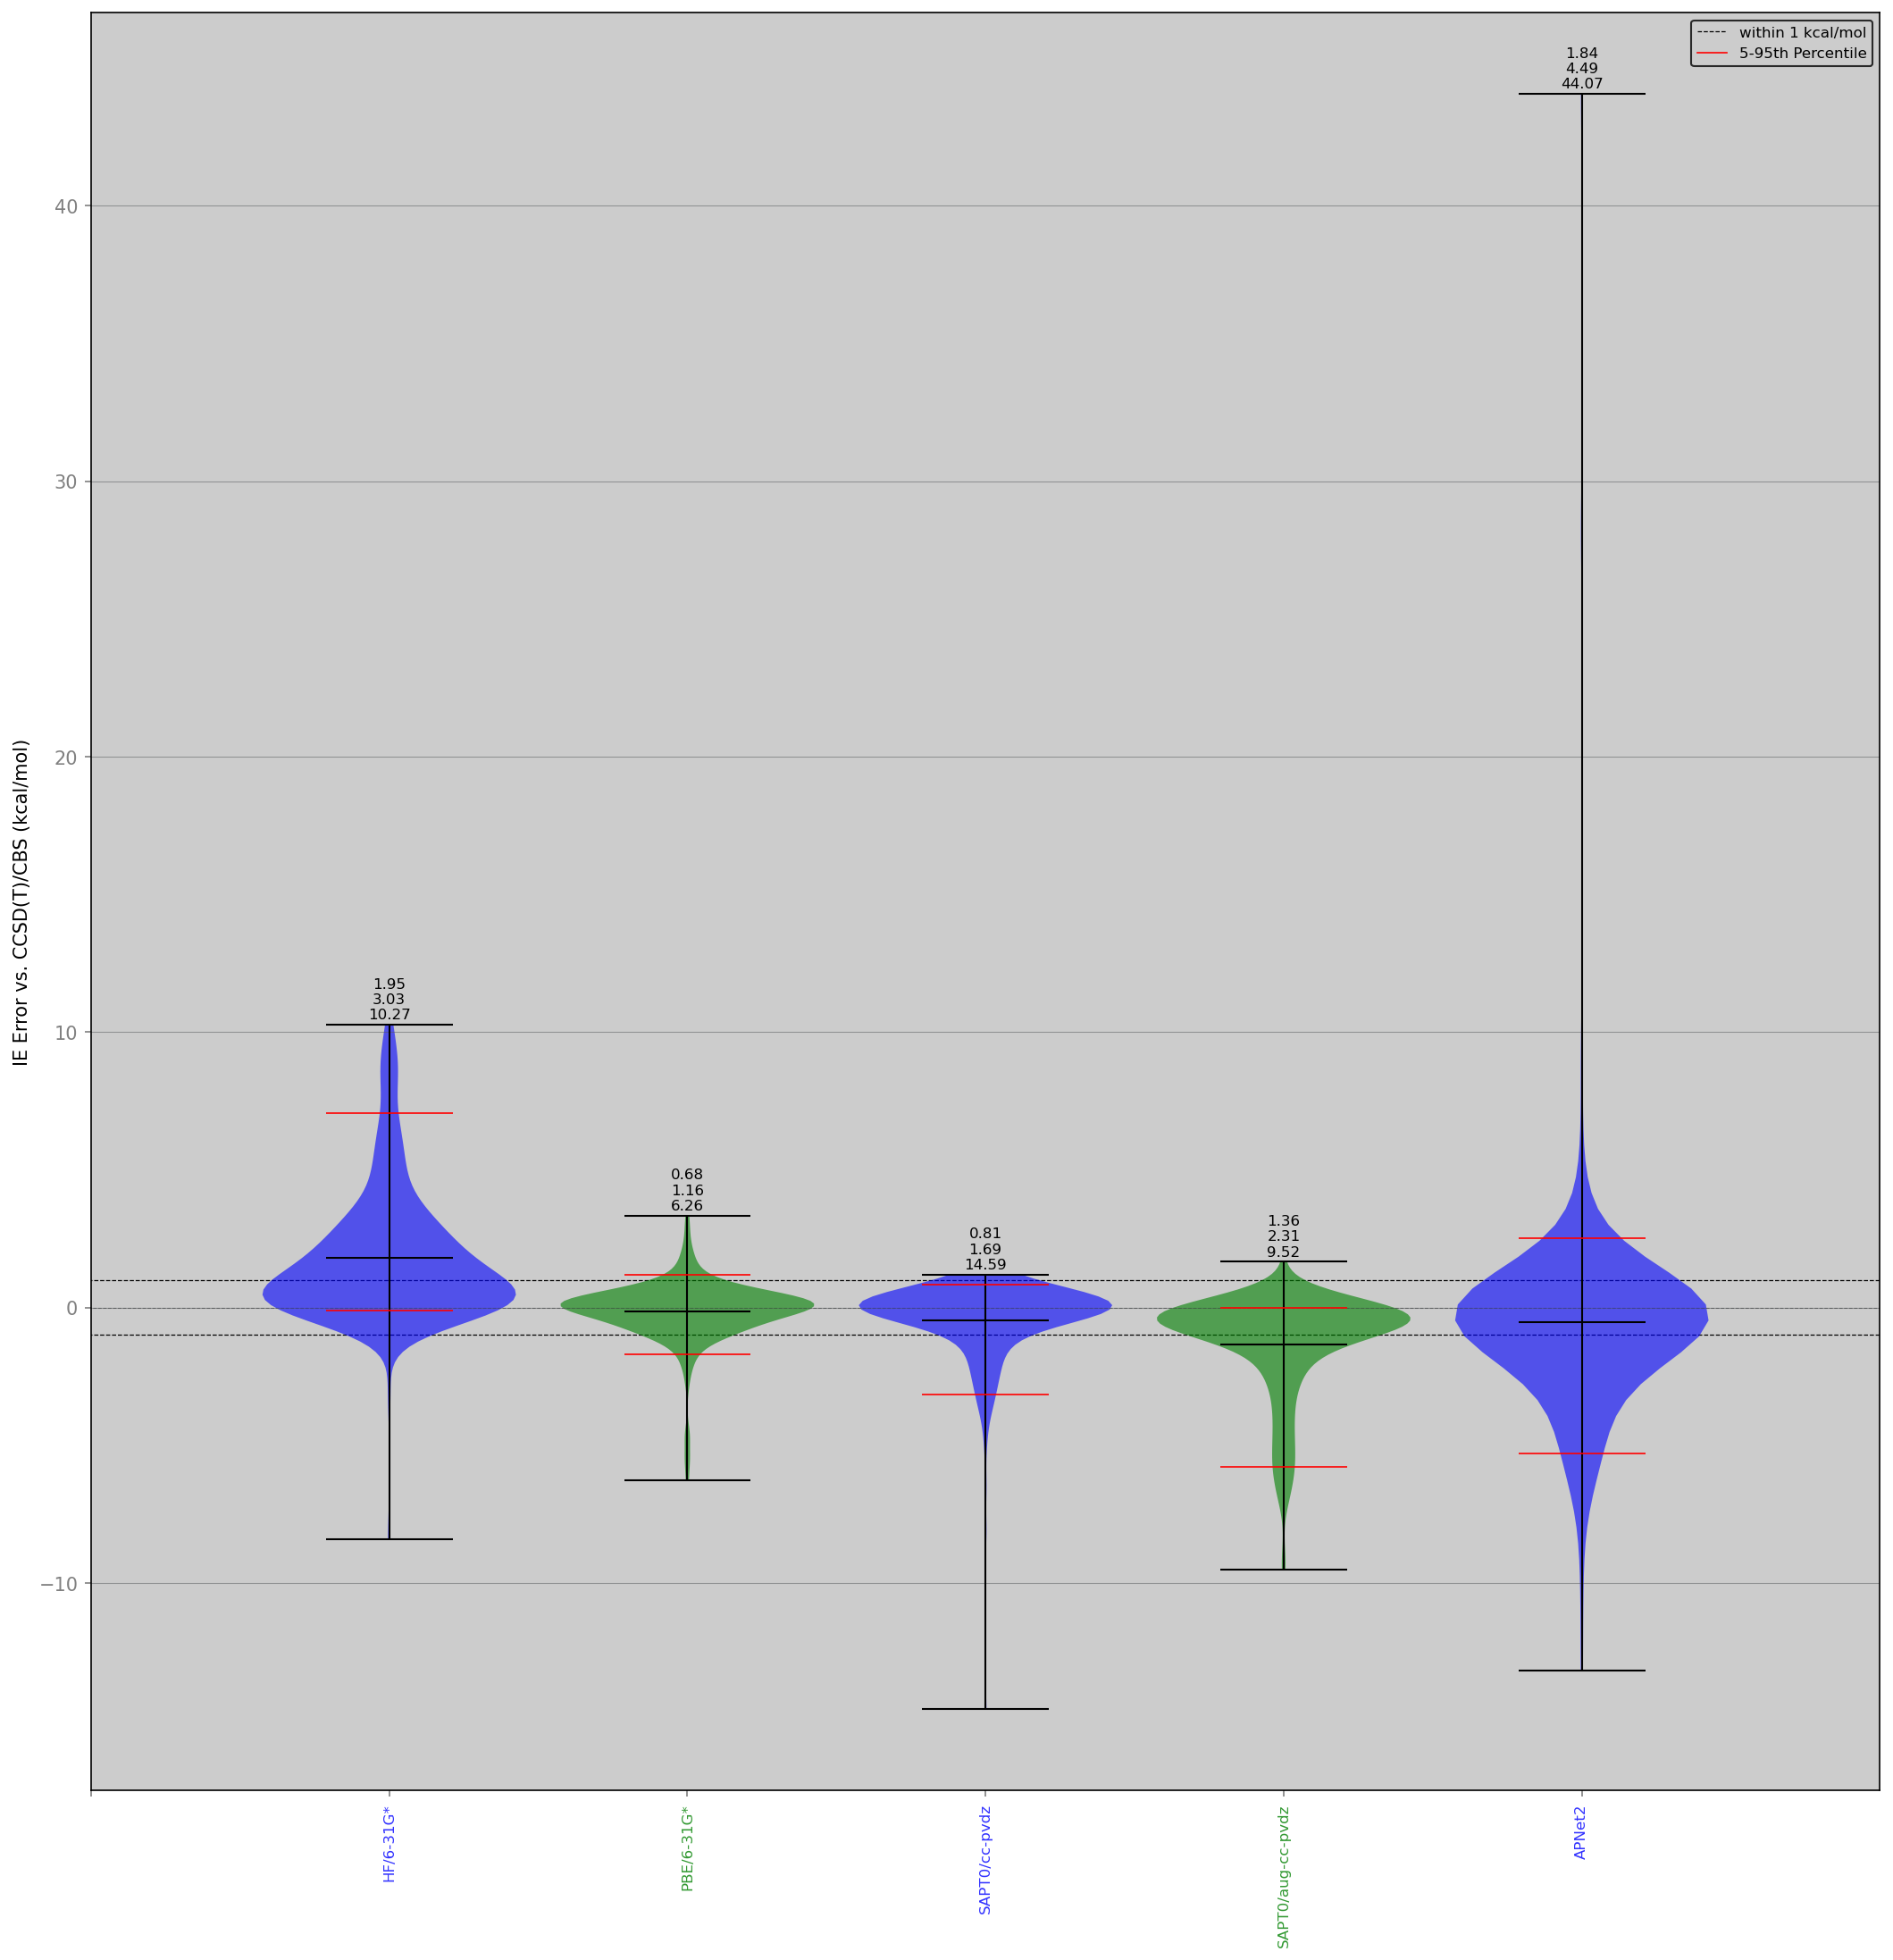

In [18]:
# AP-Net2 IE
df_plot['APNet2'] = np.sum(apnet2_ies_predicted, axis=1)
df_plot['APNet2 error'] = (df_plot['APNet2'] - df_plot['reference']).astype(float)
print(df_plot.sort_values(by='APNet2 error', ascending=True)[['APNet2', 'reference']])
error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        "SAPT0/cc-pvdz": "SAPT0/cc-pvdz error",
        "SAPT0/aug-cc-pvdz": "SAPT0/aug-cc-pvdz error",
        "APNet2": "APNet2 error",
    },
    output_filename="S22-IE-AP2.png",
    rcParams={},
    usetex=False,
    figure_size=(4, 4),
    ylabel=r"IE Error vs. CCSD(T)/CBS (kcal/mol)",
)

In [19]:
# Training models on new QM data: Transfer Learning

from apnet_pt import pairwise_datasets

ds2 = pairwise_datasets.apnet2_module_dataset(
    root="data_dir",
    spec_type=None,
    atom_model=atom_model,
    qcel_molecules=df_plot['qcel_molecule'].tolist(),
    energy_labels=[np.array([i]) for i in df_plot['reference'].tolist()],
    skip_compile=True,
    force_reprocess=True,
    atomic_batch_size=8,
    prebatched=False,
    in_memory=True,
    batch_size=4,
)
print(ds2)

Received 200 QCElemental molecules with energy labels
Processing directly from provided QCElemental molecules...
Processing 200 dimers from provided QCElemental molecules...
Creating data objects...
len(RAs)=200, self.atomic_batch_size=8, self.batch_size=4
0/200, 0.02s, 0.02s
8/200, 0.02s, 0.04s
16/200, 0.02s, 0.06s
24/200, 0.02s, 0.08s
32/200, 0.02s, 0.10s
40/200, 0.02s, 0.11s
48/200, 0.02s, 0.14s
56/200, 0.01s, 0.15s
64/200, 0.02s, 0.17s
72/200, 0.02s, 0.19s
80/200, 0.02s, 0.20s
88/200, 0.02s, 0.22s
96/200, 0.02s, 0.24s
104/200, 0.01s, 0.26s
112/200, 0.02s, 0.28s
120/200, 0.02s, 0.29s
128/200, 0.01s, 0.31s
136/200, 0.02s, 0.32s
144/200, 0.02s, 0.34s
152/200, 0.02s, 0.36s
160/200, 0.02s, 0.38s
168/200, 0.02s, 0.40s
176/200, 0.01s, 0.41s
184/200, 0.02s, 0.43s
192/200, 0.02s, 0.44s
Processing directly from provided QCElemental molecules...
Processing 200 dimers from provided QCElemental molecules...
Creating data objects...
len(RAs)=200, self.atomic_batch_size=8, self.batch_size=4
0/200

## Transfer Learning

In [20]:
# Transfer Learning APNet2 model on computed QM data
ap2.train(
    dataset=ds2,
    n_epochs=50,
    transfer_learning=True,
    skip_compile=True,
    model_path="apnet2_transfer_learning.pt",
    split_percent=0.8,
)

Saving training results to...
apnet2_transfer_learning.pt
~~ Training APNet2Model ~~
    Training on 160 samples, Testing on 40 samples

Network Hyperparameters:
  self.model.n_message=3
  self.model.n_neuron=128
  self.model.n_embed=8
  self.model.n_rbf=8
  self.model.r_cut=5.0
  self.model.r_cut_im=8.0

Training Hyperparameters:
  n_epochs=50
  lr=0.0005

  lr_decay=None

  batch_size=4
Running single-process training
                                       Total
  (Pre-training) (0.69   s)  MAE:   1.970/1.193  
  EPOCH:    0 (1.12   s)  MAE:   1.837/0.934   *
  EPOCH:    1 (1.13   s)  MAE:   1.951/0.879   *
  EPOCH:    2 (1.10   s)  MAE:   1.082/0.835    
  EPOCH:    3 (1.10   s)  MAE:   0.750/0.855    
  EPOCH:    4 (1.10   s)  MAE:   0.477/0.743    
  EPOCH:    5 (1.12   s)  MAE:   0.375/0.712   *
  EPOCH:    6 (1.10   s)  MAE:   0.329/0.695    
  EPOCH:    7 (1.11   s)  MAE:   0.332/0.761    
  EPOCH:    8 (1.10   s)  MAE:   0.581/0.766    
  EPOCH:    9 (1.10   s)  MAE:   0.445/0

Plotting S22-IE-AP2.png
S22-IE-AP2_violin.png


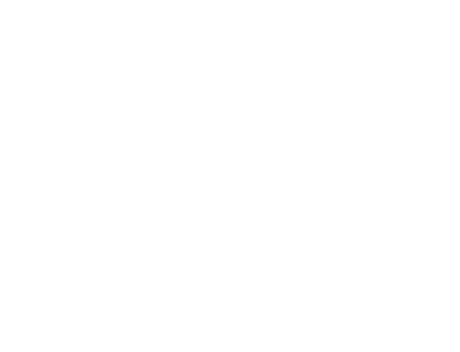

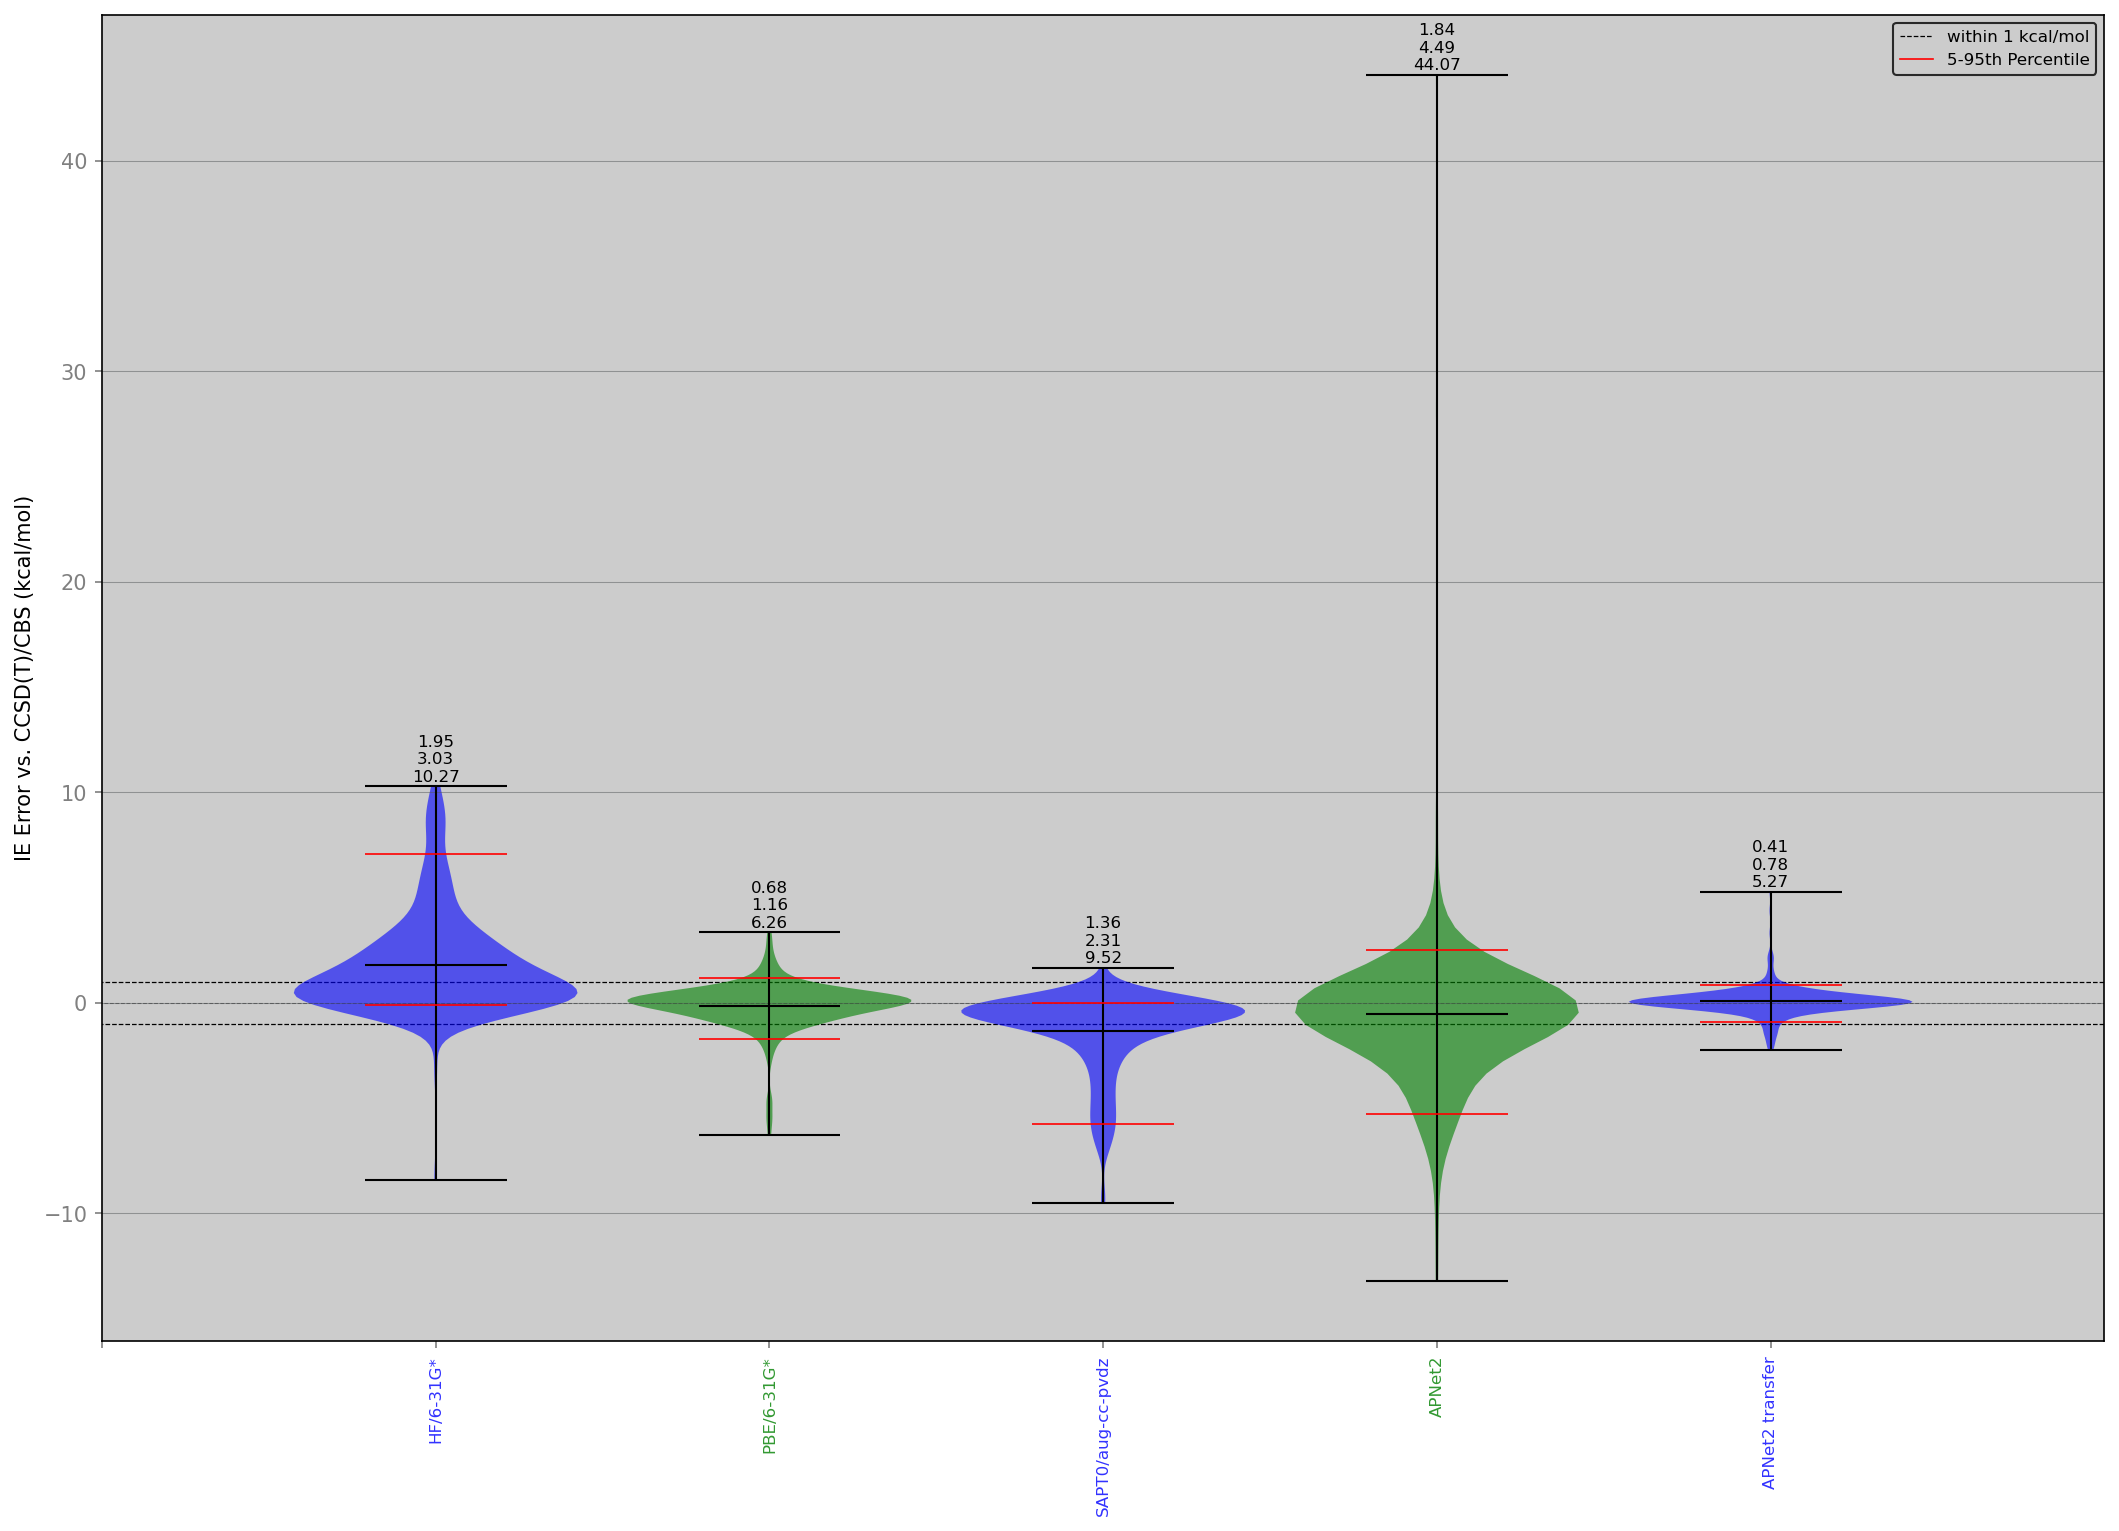

In [21]:
# AP-Net2 IE
apnet2_ies_predicted_transfer = ap2.predict_qcel_mols(
    mols=df_plot['qcel_molecule'].tolist(),
    batch_size=16,
)
df_plot['APNet2 transfer'] = np.sum(apnet2_ies_predicted_transfer, axis=1)
df_plot['APNet2 transfer error'] = (df_plot['APNet2 transfer'] - df_plot['reference']).astype(float)

error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        "SAPT0/aug-cc-pvdz": "SAPT0/aug-cc-pvdz error",
        "APNet2": "APNet2 error",
        "APNet2 transfer": "APNet2 transfer error",
    },
    output_filename="S22-IE-AP2.png",
    rcParams={},
    usetex=False,
    figure_size=(6, 4),
    ylabel=r"IE Error vs. CCSD(T)/CBS (kcal/mol)",
)

## $\Delta$AP-Net2

In [22]:
from apnet_pt.pt_datasets.dapnet_ds import dapnet2_module_dataset_apnetStored

delta_energies = df_plot['HF/6-31G* error'].tolist()

# Only operates in pre-batched mode
ds = dapnet2_module_dataset_apnetStored(
    root="data_dir",
    r_cut=5.0,
    r_cut_im=8.0,
    spec_type=None,
    max_size=None,
    force_reprocess=True,
    batch_size=2,
    num_devices=1,
    skip_processed=False,
    skip_compile=True,
    print_level=2,
    in_memory=True,
    m1="HF/6-31G*",
    m2="CCSD(T)/CBS",
    qcel_molecules=df_plot['qcel_molecule'].tolist(),
    energy_labels=delta_energies,
)
print(ds)

Received 200 QCElemental molecules with energy labels
running on the CPU
running on the CPU
Loading pre-trained APNet2_MPNN model from /home/amwalla3/gits/qcmlforge/src/apnet_pt/models/ap2_ensemble/ap2_0.pt
self.dataset=None
raw_path: data_dir/raw/splinter_spec1.pkl
Loading dimers...
Creating data objects...
len(qcel_mols)=200, self.batch_size=2
raw_path: data_dir/raw/splinter_spec1.pkl
Loading dimers...
Creating data objects...
len(qcel_mols)=200, self.batch_size=2
self.root='data_dir', self.spec_type=None, self.in_memory=True
raw_path: data_dir/raw/splinter_spec1.pkl
Loading dimers...
Saving to data_dir/processed_delta/targets_HF6-31G_to_CCSD_LP_T_RP_CBS.pt
dapnet2_module_dataset_apnetStored(100)


In [23]:
from apnet_pt.AtomPairwiseModels.dapnet2 import dAPNet2Model

dap2 = dAPNet2Model(
    atom_model=AtomModel().set_pretrained_model(model_id=0),
    apnet2_model=APNet2Model().set_pretrained_model(model_id=0).set_return_hidden_states(True),
)
dap2.train(
    ds,
    n_epochs=50,
    skip_compile=True,
    split_percent=0.6,
)

running on the CPU
running on the CPU
self.dataset=None
running on the CPU
None
Saving training results to...
None
~~ Training APNet2Model ~~
    Training on 60 samples, Testing on 40 samples

Network Hyperparameters:
  self.model.n_neuron=128

Training Hyperparameters:
  n_epochs=50
  lr=0.0005

  lr_decay=None

  batch_size=1
Running single-process training
num_workers = 4
                                       Energy
  (Pre-training) (0.23   s)  MAE:   1.905/2.126  
  EPOCH:    0 (0.28   s)  MAE:   1.118/1.079   *
  EPOCH:    1 (0.30   s)  MAE:   0.798/0.955   *
  EPOCH:    2 (0.29   s)  MAE:   0.666/0.886   *
  EPOCH:    3 (0.28   s)  MAE:   0.571/0.809   *
  EPOCH:    4 (0.27   s)  MAE:   0.551/0.858    
  EPOCH:    5 (0.27   s)  MAE:   0.505/0.743   *
  EPOCH:    6 (0.28   s)  MAE:   0.419/0.738    
  EPOCH:    7 (0.27   s)  MAE:   0.361/0.652   *
  EPOCH:    8 (0.28   s)  MAE:   0.503/0.794    
  EPOCH:    9 (0.28   s)  MAE:   0.413/0.639   *
  EPOCH:   10 (0.28   s)  MAE:   0.3

              dAPNet2   HF/6-31G* HF/6-31G*-dAPNet2  reference
entry                                                         
S22-IE-0     2.844362   -15.29702        -18.141381    -18.075
S22-IE-1     0.395527   -4.790555         -5.186082     -5.220
S22-IE-2     1.229590       -3.52          -4.74959     -4.700
S22-IE-3     0.111827   -0.441187         -0.553014     -0.420
S22-IE-4     0.394805   -8.814418         -9.209223     -9.210
S22-IE-5     4.840552  -14.037943        -18.878495    -18.790
S22-IE-6     0.564343    -4.02006         -4.584403     -4.570
S22-IE-7     0.174819   -3.383401         -3.558221     -3.528
S22-IE-8     1.409660   -6.188112         -7.597772     -7.460
S22-IE-9     4.679161   -14.98262        -19.661781    -19.650
S22-IE-10   -0.062969    -1.21354         -1.150571     -1.200
S22-IE-11   -2.949284  -35.661351        -32.712067    -32.500
S22-IE-12    0.367229   -0.971568         -1.338798     -1.310
S22-IE-13    1.352297   -1.773877         -3.126174    

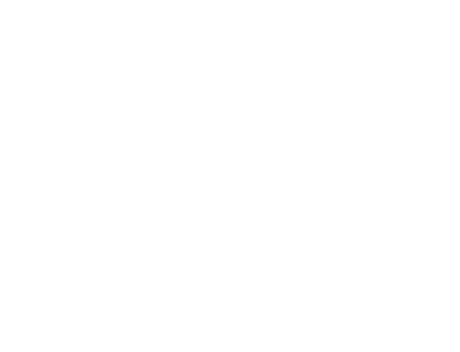

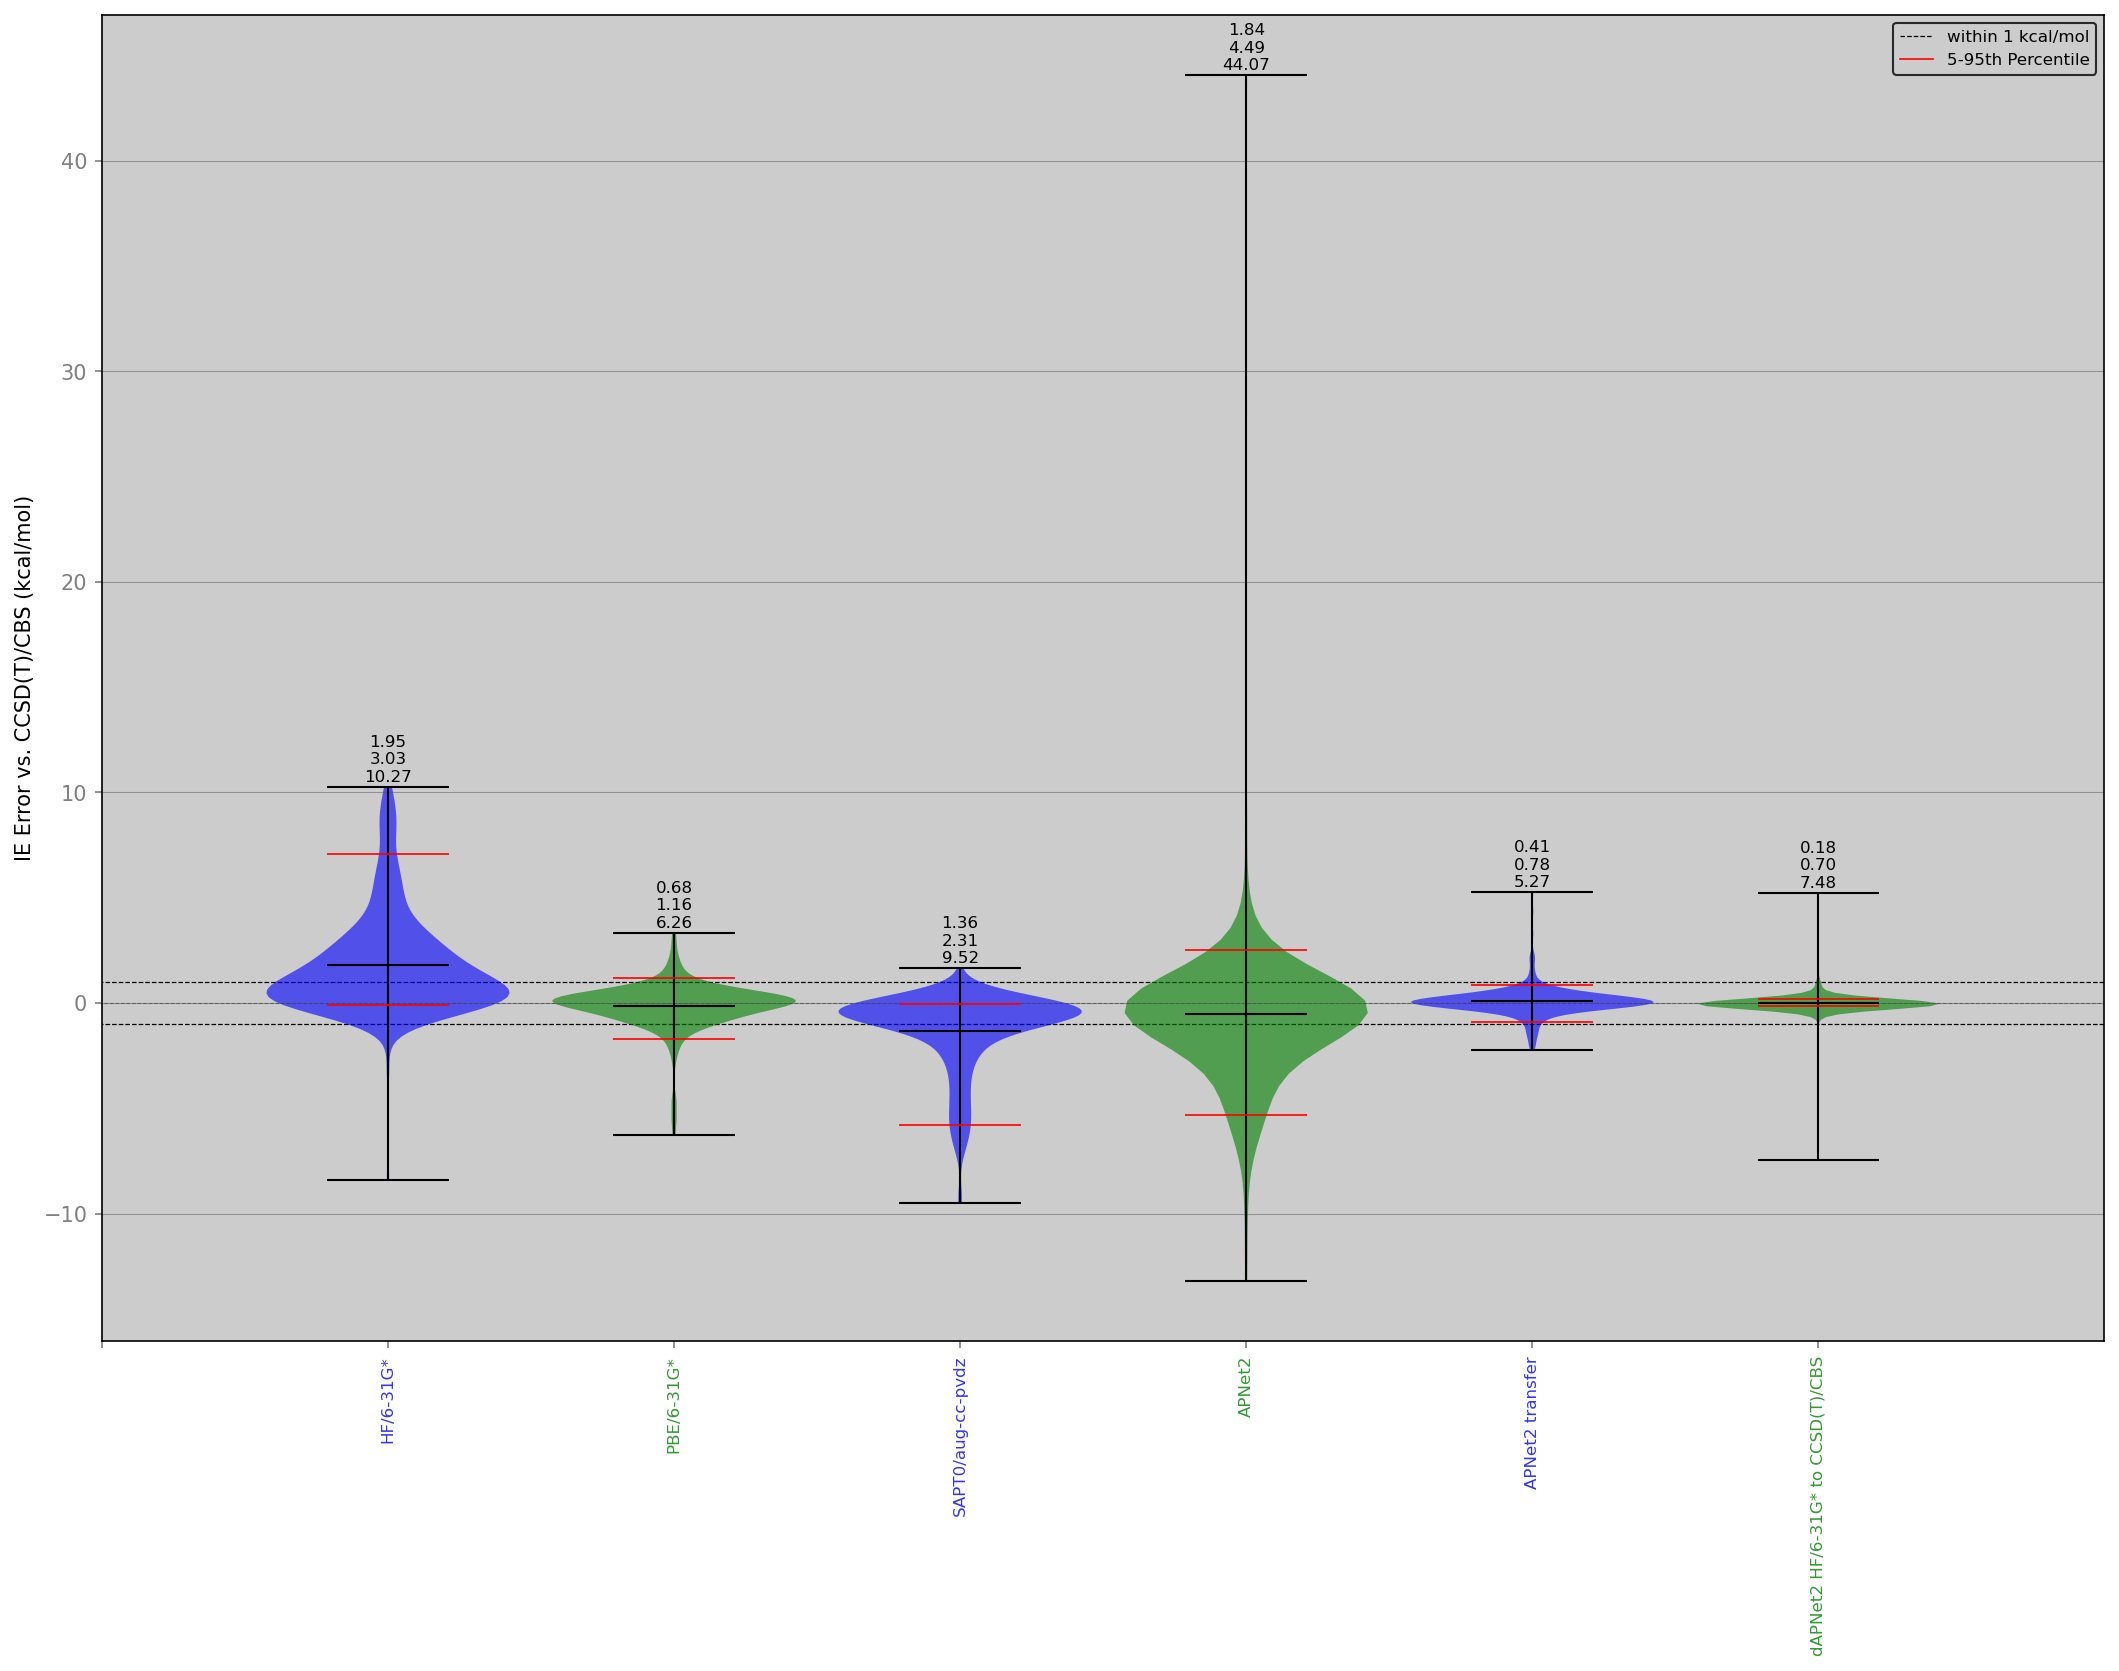

In [24]:
dAPNet2_ies_predicted_transfer = dap2.predict_qcel_mols(
    mols=df_plot['qcel_molecule'].tolist(),
    batch_size=2,
)
df_plot['dAPNet2'] = dAPNet2_ies_predicted_transfer
df_plot['HF/6-31G*-dAPNet2'] = df_plot['HF/6-31G*'] - df_plot['dAPNet2']
print(df_plot[['dAPNet2', 'HF/6-31G*', 'HF/6-31G*-dAPNet2',  'reference']])
df_plot['dAPNet2 error'] = (df_plot['HF/6-31G*-dAPNet2'] - df_plot['reference']).astype(float)

error_statistics.violin_plot(
    df_plot,
    df_labels_and_columns={
        "HF/6-31G*": "HF/6-31G* error",
        "PBE/6-31G*": "PBE/6-31G* error",
        "SAPT0/aug-cc-pvdz": "SAPT0/aug-cc-pvdz error",
        "APNet2": "APNet2 error",
        "APNet2 transfer": "APNet2 transfer error",
        "dAPNet2 HF/6-31G* to CCSD(T)/CBS": "dAPNet2 error",
    },
    output_filename="S22-IE-AP2-dAP2.png",
    rcParams={},
    usetex=False,
    figure_size=(6, 4),
    ylabel=r"IE Error vs. CCSD(T)/CBS (kcal/mol)",
)

In [ ]:
# Be careful with this for it can corrupt running status...
# !ps aux | grep qcfractal | awk '{ print $2 }' | xargs kill -9

# The end...

     Benchmark  ... SAPT0 TOTAL ENERGY adz
0      -10.248  ...              -0.018254
1      -15.245  ...              -0.027620
2       -3.517  ...              -0.005920
3       -0.127  ...              -0.000192
4       -8.990  ...              -0.016209
..         ...  ...                    ...
353     -4.390  ...              -0.008013
354     -1.130  ...              -0.002090
355     -0.260  ...              -0.000503
356     -5.740  ...              -0.009757
357     -3.120  ...              -0.005630

[358 rows x 4 columns]
count    100.000000
mean      11.970000
std        2.750409
min        3.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       16.000000
Name: size, dtype: float64
0     Molecule(name='C2H4O4', formula='C2H4O4', hash...
1     Molecule(name='CH7NO', formula='CH7NO', hash='...
2     Molecule(name='C3H9NO2', formula='C3H9NO2', ha...
3     Molecule(name='C6H8O', formula='C6H8O', hash='...
4     Molecule(name='C4H8O4', formula='C4H8O4', h